# Import libraries

In [1]:
#Import python libs
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import expon
from scipy.stats import norm
from scipy.stats import uniform
from numpy.random import random
import scipy.optimize as opt
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 18})
import warnings
warnings.filterwarnings("ignore")

# Define functions

In [2]:
def calc_CCC(D1, D2):
    
    """
    Defintion: This function calculate the correspondance correlation coefficient for two sets of data 
    
    Inputs:
    data = dataset with 2 columns, test 1 and test 2
    
    Outputs:
    CCC = correspondence correlation coefficient
    
    """
    mu1 = np.mean(D1)
    mu2 = np.mean(D2)
    var1 = np.sum((D1-mu1)**2) / (len(D1))
    var2 = np.sum((D2-mu2)**2) / (len(D2))
    cov = np.sum((D1 - mu1)*(D2-mu2)) / (len(D1))

    #calculate the CCC
    CCC = (2*cov) / (var1+var2 + (mu1-mu2)**2)

    return CCC

In [3]:
def UniqueVals(stims, responses):
    
    """
    Definition: Takes stimulus values and responses and calculates N (total number of trials) and K (number of responses of interest) 
    for each unique stimulus values
    
    Inputs:
    stims = vector of all stimuli
    responses = vector of all responses
    
    Outputs:
    unique_stims = vector of the unrepeated stimulus locations
    Nstims = the number of times each unique stim was visited (vector)
    Kleft = the number of times the response was left at each stim location
    """
    
    unique_stims, stim_idx = np.unique(stims, return_index=True)
    Nstims, Kleft = [], []
    for u in unique_stims:
        stim_idx = np.argwhere(u==stims)
        Nstims = np.append(Nstims,len(stim_idx))
        Kleft = np.append(Kleft, np.sum(responses[stim_idx]))
        
    return unique_stims, Nstims, Kleft

In [4]:
def nloglik(params,X,N,K):
    
    """
    Definition: This function returns the negative log likelihood of the parameters mu and sigma 
    for a data set 
    
    inputs:
    X = stimuli (vector)
    N = number of trials at each X 
    K = Number of trials with the response of interest
    
    outputs:
    nll = negative log likelihood
    """
    
    alpha=params[0]
    beta=params[1]
    
    psi = norm.cdf(X,alpha,beta)       
    ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))

    nll = -ll
    
    return nll

In [5]:
def Fit_psi(stims, Kleft, Nstims, Num_Inits):
    
    """
    Definition: Uses MLE to fit a psychometric function (normcdf) to data
    
    inputs:
    stims = vector of all stimulus values 
    responses = vector of all responses
    Num_Inits = number of initializations
    
    outputs:
    best_params = best paramers (size 2 vector)
    best_ll = log likelihood of the best parameters
    """   
    
    temp_ll = []
    temp_params = np.empty((Num_Inits,2))
    for i in range(Num_Inits):

        x0 = [norm.rvs(0,20), expon.rvs(0,20)]
        res = opt.minimize(nloglik, x0=x0, args=(stims,Nstims,Kleft),
                method='Nelder-Mead', bounds=((-50,50),(0,50)), options={'disp': False})
        
        temp_ll = np.append(temp_ll, res.fun)
        temp_params[i,:] = res.x

    min_idx = np.nanargmin(temp_ll)
    best_params = temp_params[min_idx]
    best_ll = temp_ll[min_idx]
    
    return best_params, best_ll

In [6]:
def sim_constants(params, X, num_trials):

    """
    Definition: Simulates a human participant using the method of constant stimuli to simulate a psychometric function
    
    inputs:
    params: 2d vector with alpha and beta as the parameters
    X = vector of the stimulus positions
    num_trials = number of trials at each stimulus locations
    
    outputs:
    Kleft = vector of len(X) with the number of times the person said left
    p_left = vector of len(X) with the probabilities of saying left 
    """
    
    alpha = params[0]
    beta = params[1]
    
    p_left, Kleft = [], []
    for x in X:
        
        psi = norm.cdf(x, alpha, beta) 
        responses = psi > np.random.rand(num_trials)
        Kleft = np.append(Kleft, sum(responses))
        p_left = np.append(p_left, sum(responses)/num_trials)
        
    return Kleft, p_left     

In [7]:
#Look up table
def Psi_lookT(X, a_range, b_range):
    
    """
    Defintion: This function creates two lookup tables required for the psi algorithm to run more efficiently
    It is a table of probabilities for both responses (left and right in this case) given all possible
    alpha and beta values and all possible stimulus locations:
    p(r='left'|alpha,beta,X)
    p(r='right'|alpha,beta,X)
    
    inputs:
    X = all stimulus positions
    a_range = vector of all possible alpha values
    b_range = vector of all possible beta values
    
    outputs:
    p_left_look = look up table for left response
    p_right_look = look up table for right response
    """
    
    #Preallocate the lookup tables
    p_left_look = np.empty([len(b_range),len(a_range),(len(X))])
    p_right_look = np.empty([len(b_range),len(a_range),(len(X))])
    
    #Loop through all possible stimulus, alpha and beta values
    for x_i, x in enumerate(X):
        for a_i, a in enumerate(a_range):
            for b_i, b in enumerate(b_range):
                psi = norm.cdf(x,a,b)
                p_left_look[b_i,a_i,x_i] = psi
                p_right_look[b_i,a_i,x_i] = 1-psi

    return p_left_look, p_right_look

In [8]:
#Entropy
def CalcH(X, p_left_look, p_right_look, Prior):
    
    """
    Definition: Calculates the expected entropy (EH) of each possible stimulus value to determine which one minimizes,
    the entropy for the next trial. This is the stimulus that will provide the most information for both parameters
    
    Inputs:
    X = vector of all stimulus values 
    p_left_look = look up table for left (size = len(b_range), len(a_range), len(X))
    p_right_look =  look up table for right (size = len(b_range), len(a_range), len(X))
    Prior = 2d prior for the parameter estiamtes (alpha and beta)
    
    Outputs:
    EH = the expected entropy function, a vector of expected entropy values for each stimulus position (X)
    best_X = the best stimulus position, the one that minimizes entropy
    """
    
    #Simulate through each possible stim value, X
    EH = []
    for i, x in enumerate(X):

        #Calculate the probability of getting a response, r, after presenting test x at the next trial (across all possible parameter values)
        p_left = np.nansum(np.nansum(np.multiply(p_left_look[:,:,i],Prior)))
        p_right = np.nansum(np.nansum(np.multiply(p_right_look[:,:,i],Prior)))

        #Calculate the posterior for each response 
        Post_left = p_left_look[:,:,i]*Prior
        Post_left = Post_left / p_left
        Post_right = p_right_look[:,:,i]*Prior
        Post_right = Post_right / p_right

        #Estimate the entropy of the posterior distribution for each response
        H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
        H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))
        
        #Combine the entropy calculations, weighted by their probabilities
        Total_H = (H_left*p_left) + (H_right*p_right)
        EH = np.append(EH, Total_H)
        
    best_X = X[np.argmin(EH)]
    return EH, best_X

In [9]:
def sim_psi(params, Ntrials, X, a_range, b_range, p_left_look, p_right_look, Prior):
    
    """
    Definition: Simulates the Psi method using the given parameters
    
    Inputs:
    params = vector of the parameters for the psychometric function (alpha, beta), in this case, it only takes two arguments
    Ntrials = number of trials to simulate
    X = vector of all stimulus values 
    a_range = vector of all possible alpha values
    b_range = vector of all possible beta values (a_range and b_range must be the same size)    
    p_left_look = look up table for left (size = len(b_range), len(a_range), len(X))
    p_right_look =  look up table for right (size = len(b_range), len(a_range), len(X))
    Prior = 2d prior for the parameter estiamtes (alpha and beta)
    
    Outputs:
    stims = vector of length Ntrials of all stimulus positions 
    responses = vector of length Ntrials of all simulated responses 
    alpha_EV = vector of length Ntrials of the alpha estimates after each trial
    beta_EV = vector of length Ntrials of the beta estimates after each trial
    """
    
    alpha = params[0]
    beta = params[1]
    
    stims, responses, alpha_EV, beta_EV = [], [], [], []
    for i in range(Ntrials):
        
        #Calculate the best stim position
        _, best_X = CalcH(X, p_left_look, p_right_look, Prior)
        stims = np.append(stims, best_X)
        
        #Simualte a response based on the parameters
        responses = np.append(responses, norm.cdf(best_X, alpha, beta) > np.random.rand())
        
        #Alt posterior calc
        stim_idx = np.argwhere(stims[i]==X)[0][0]
        if responses[i]==1:
            Posterior = p_left_look[:,:,stim_idx]*Prior
        elif responses[i]==0:
            Posterior = p_right_look[:,:,stim_idx]*Prior
        Posterior = Posterior/np.nansum(np.nansum(Posterior))
        
        #Marginalize the posterior
        alpha_post = np.nansum(Posterior,axis=0)
        beta_post = np.nansum(Posterior,axis=1)
        
        #Calculate the expected value of each
        alpha_EV = np.append(alpha_EV, np.nansum(a_range*alpha_post))
        beta_EV = np.append(beta_EV, np.nansum(b_range*beta_post))
        
        #The posterior becomes the prior for the next trial
        Prior = Posterior        
        
    return stims, responses, alpha_EV, beta_EV

# Set variables for each method

## Set the lookup table and the prior (for psi method)

In [10]:
X = np.arange(-100,110,10)
a_range = np.linspace(-100,100,201) 
b_range = np.linspace(0.001,100,201)
p_left_look, p_right_look = Psi_lookT(X, a_range, b_range)

#Set the priors
p_alpha = norm.pdf(a_range,0, 20)
p_beta = expon.pdf(b_range,0,20)
p_alpha = np.reshape(p_alpha,(1,len(p_alpha)))
p_beta = np.reshape(p_beta,(1,len(p_beta)))
Prior = p_beta.T @ p_alpha 

## Set stimuli range for the method of constants

In [11]:
#Logspace the array so it can cover a wider space
X_constants = np.round(np.logspace(1,2,4))
X_constants = np.concatenate((-np.flip(X_constants), np.zeros(1), X_constants))
X_constants

array([-100.,  -46.,  -22.,  -10.,    0.,   10.,   22.,   46.,  100.])

# Simulate an individual

For a fair comparison, we should make an equal number of trials. To give the method of constants a chance, we should run at least 10 simulations per stim location, a total of 90 trials given the 9 different stimulus locations. 

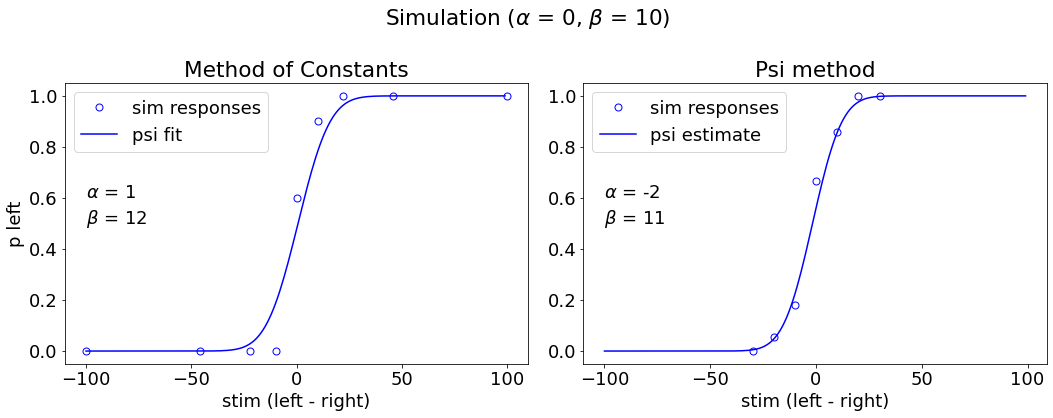

In [12]:
#Set the parameters
alpha, beta = 0, 10
params = [alpha, beta]

#Set the trials per stim
trials_per_stim = 10
Ntrials = trials_per_stim*len(X_constants)

#Simulate Psi
stims, responses, alpha_EV, beta_EV = sim_psi(params, Ntrials, X, a_range, b_range, p_left_look, p_right_look, Prior)
psi_psi = norm.cdf(np.arange(-100,100), alpha_EV[-1], beta_EV[-1])
unique_stims, Nstims_psi, Kleft_psi = UniqueVals(stims, responses)

#Simulate Constants 
Kleft, p_left = sim_constants(params, X_constants, trials_per_stim)

#Fit the constants data
Nstims = np.ones_like(X_constants)*trials_per_stim
best_params, _ = Fit_psi(X_constants, Kleft, Nstims, Num_Inits=30)
psi_constants = norm.cdf(np.arange(-100,100),best_params[0],best_params[1])

#Plot
fig, ax = plt.subplots(1,2, figsize=(15,6), tight_layout=True)
ax[0].plot(X_constants, p_left, 'bo', mfc='w', ms=7, label='sim responses')
ax[0].plot(np.arange(-100,100), psi_constants, 'b', label='psi fit')
ax[0].text(-100,0.6, r'$\alpha$ = ' + str(round(best_params[0])))
ax[0].text(-100,0.5, r'$\beta$ = ' + str(round(best_params[1])))
ax[0].set(title='Method of Constants', ylabel='p left', xlabel='stim (left - right)')
ax[0].legend()

ax[1].plot(unique_stims, Kleft_psi/Nstims_psi, 'bo', mfc='w', ms=7, label='sim responses')
ax[1].plot(np.arange(-100,100), psi_psi, 'b', label='psi estimate')
ax[1].text(-100,0.6, r'$\alpha$ = ' + str(round(alpha_EV[-1])))
ax[1].text(-100,0.5, r'$\beta$ = ' + str(round(beta_EV[-1])))
ax[1].set(title='Psi method', xlabel='stim (left - right)')
ax[1].legend()
fig.suptitle(r'Simulation ($\alpha$ = ' + str(alpha) + r', $\beta$ = ' + str(beta) + ')')
plt.show()

# Simulate a group of individulas (randomized parameters) 

In [13]:
#Number of sims per alpha and beta
Nsubjs = 50

#Set the trials per stim
trials_per_stim = 10
Ntrials = trials_per_stim*len(X_constants)

In [14]:
alpha_sim, beta_sim, alpha_psi, beta_psi, alpha_constants, beta_constants = [],[],[],[],[],[]
for n in range(Nsubjs):

    alpha_sim = np.append(alpha_sim, norm.rvs(0,20))
    beta_sim = np.append(beta_sim, expon.rvs(0,20))
    params = [alpha_sim[n], beta_sim[n]]
    
    #Simulate Psi
    _, _, alpha_EV, beta_EV = sim_psi(params, Ntrials, X, a_range, b_range, p_left_look, p_right_look, Prior)
    alpha_psi = np.append(alpha_psi, alpha_EV[-1]) 
    beta_psi = np.append(beta_psi, beta_EV[-1])

    #Simulate Constants 
    Kleft, p_left = sim_constants(params, X_constants, trials_per_stim)
    #Fit the constants data
    Nstims = np.ones_like(X_constants)*trials_per_stim
    best_params, _ = Fit_psi(X_constants, Kleft, Nstims, Num_Inits=30)

    alpha_constants = np.append(alpha_constants, best_params[0])
    beta_constants = np.append(beta_constants, best_params[1])

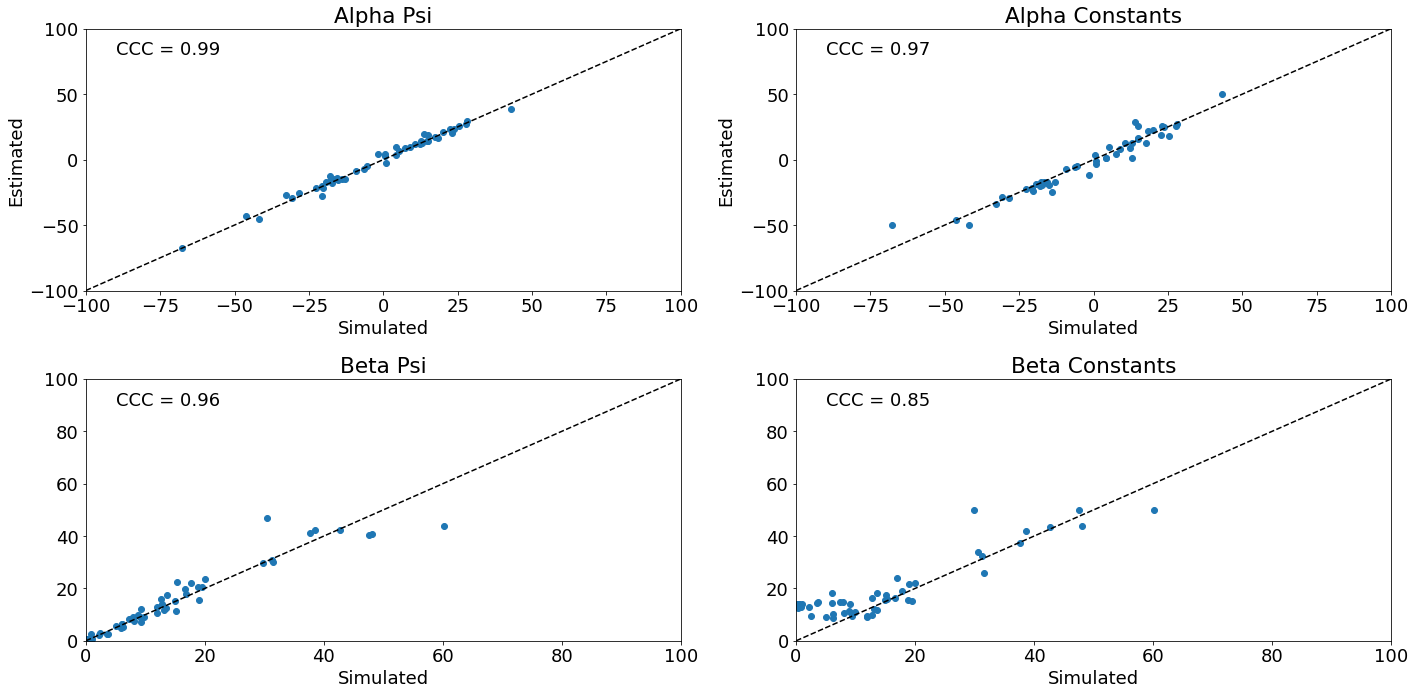

In [15]:
alpha_psi_ccc = calc_CCC(alpha_sim,alpha_psi)
alpha_const_ccc = calc_CCC(alpha_sim,alpha_constants)
beta_psi_ccc = calc_CCC(beta_sim,beta_psi)
beta_const_ccc = calc_CCC(beta_sim,beta_constants)

#Plot
fig, ax = plt.subplots(2,2,figsize=(20,10), tight_layout=True)
ax[0,0].plot(alpha_sim,alpha_psi,'o')
ax[0,0].plot(a_range,a_range,'k--')
ax[0,0].text(-90,80,'CCC = ' + str(round(alpha_psi_ccc,2)))
ax[0,0].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated',ylabel='Estimated',title='Alpha Psi')

ax[1,0].plot(beta_sim,beta_psi,'o')
ax[1,0].plot(b_range,b_range,'k--')
ax[1,0].text(5,90,'CCC = ' + str(round(beta_psi_ccc,2)))
ax[1,0].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated',title='Beta Psi')

ax[0,1].plot(alpha_sim,alpha_constants,'o')
ax[0,1].plot(a_range,a_range,'k--')
ax[0,1].text(-90,80,'CCC = ' + str(round(alpha_const_ccc,2)))
ax[0,1].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated',ylabel='Estimated',title='Alpha Constants')

ax[1,1].plot(beta_sim,beta_constants,'o')
ax[1,1].plot(b_range,b_range,'k--')
ax[1,1].text(5,90,'CCC = ' + str(round(beta_const_ccc,2)))
ax[1,1].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated',title='Beta Constants')
plt.show()

# Simulate Group of individuals (pre-set parameters)

In [29]:
#Preset parameters
alphas = np.arange(-50,55,5)
betas = np.arange(1,55,5)

#Number of sims per alpha and beta
Nsubjs = 10

#Set the trials per stim
trials_per_stim = 10
Ntrials = trials_per_stim*len(X_constants)

In [30]:
alpha_sim, beta_sim, alpha_psi, beta_psi, alpha_constants, beta_constants = [],[],[],[],[],[]
for a in alphas:
    for b in betas:
        for n in range(Nsubjs):
            
            alpha_sim = np.append(alpha_sim, a)
            beta_sim = np.append(beta_sim, b)
            
            params = [a,b]
            
            #Simulate Psi
            _, _, alpha_EV, beta_EV = sim_psi(params, Ntrials, X, a_range, b_range, p_left_look, p_right_look, Prior)
            alpha_psi = np.append(alpha_psi, alpha_EV[-1]) 
            beta_psi = np.append(beta_psi, beta_EV[-1])

            #Simulate Constants 
            Kleft, p_left = sim_constants(params, X_constants, trials_per_stim)
            #Fit the constants data
            Nstims = np.ones_like(X_constants)*trials_per_stim
            best_params, _ = Fit_psi(X_constants, Kleft, Nstims, Num_Inits=30)
            
            alpha_constants = np.append(alpha_constants, best_params[0])
            beta_constants = np.append(beta_constants, best_params[1])

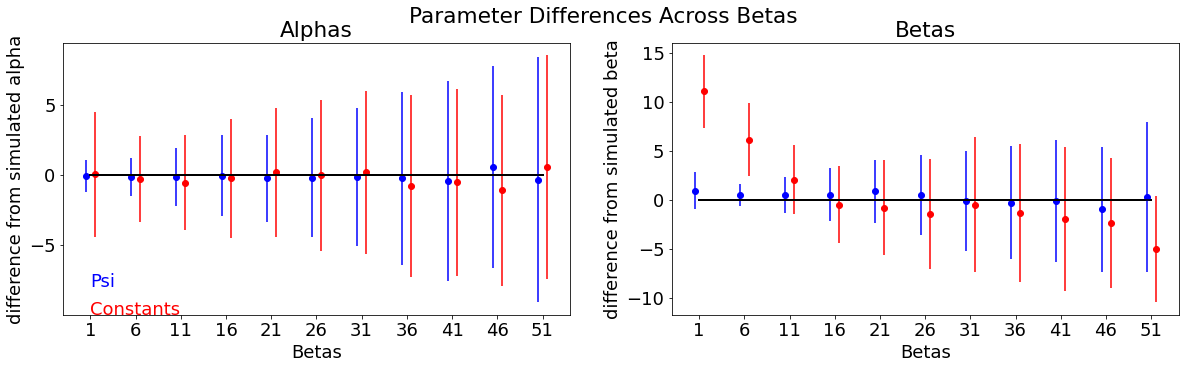

In [31]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
#Look at alphas in each beta 
for i, b in enumerate(betas): 
    b_idx = np.argwhere(b==beta_sim)
    alpha_psi_diff = alpha_psi[b_idx] - alpha_sim[b_idx]
    alpha_const_diff = alpha_constants[b_idx] - alpha_sim[b_idx]
    beta_psi_diff = beta_psi[b_idx] - beta_sim[b_idx]
    beta_const_diff = beta_constants[b_idx] - beta_sim[b_idx]
    
    #Plot
    ax[0].plot(i-0.1, np.mean(alpha_psi_diff), 'bo', label='Psi')
    ax[0].errorbar(i-0.1, np.mean(alpha_psi_diff), np.std(alpha_psi_diff), ecolor='b')
    ax[0].plot(i+0.1, np.mean(alpha_const_diff), 'ro', label='Constants')
    ax[0].errorbar(i+0.1, np.mean(alpha_const_diff), np.std(alpha_const_diff), ecolor='r')
    ax[0].plot(np.arange(len(betas)),np.zeros(len(betas)),'k')
    
    ax[1].plot(i-0.1, np.mean(beta_psi_diff), 'bo', label='Psi')
    ax[1].errorbar(i-0.1, np.mean(beta_psi_diff), np.std(beta_psi_diff), ecolor='b')
    ax[1].plot(i+0.1, np.mean(beta_const_diff), 'ro', label='Constants')
    ax[1].errorbar(i+0.1, np.mean(beta_const_diff), np.std(beta_const_diff), ecolor='r')
    ax[1].plot(np.arange(len(betas)),np.zeros(len(betas)),'k')    
    
ax[0].set(title='Alphas', xticks=np.arange(len(betas)), xticklabels=betas, xlabel='Betas', ylabel='difference from simulated alpha') 
ax[0].text(0, -8, 'Psi', color='b')
ax[0].text(0, -10, 'Constants', color='r')
ax[1].set(title='Betas', xticks=np.arange(len(betas)), xticklabels=betas, xlabel='Betas', ylabel='difference from simulated beta') 
fig.suptitle('Parameter Differences Across Betas')
plt.show()

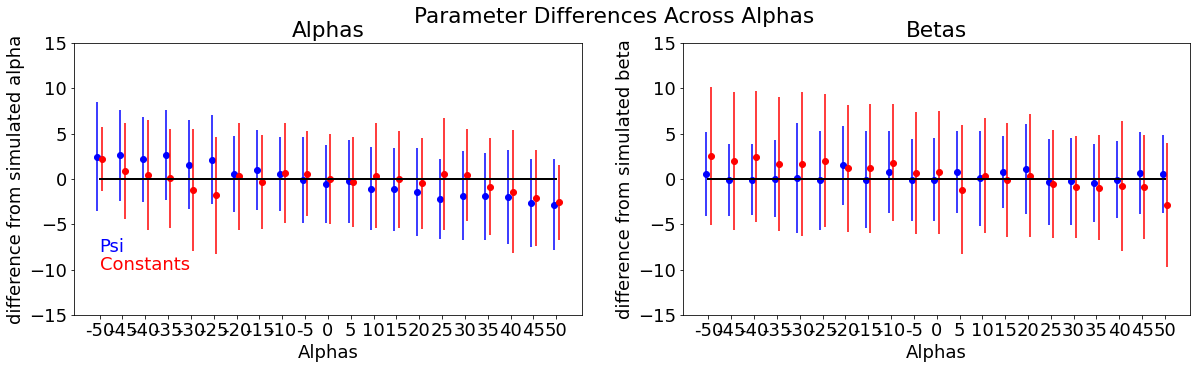

In [32]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
#Look differences across alphas 
for i, a in enumerate(alphas): 
    a_idx = np.argwhere(a==alpha_sim)
    alpha_psi_diff = alpha_psi[a_idx] - alpha_sim[a_idx]
    alpha_const_diff = alpha_constants[a_idx] - alpha_sim[a_idx]
    beta_psi_diff = beta_psi[a_idx] - beta_sim[a_idx]
    beta_const_diff = beta_constants[a_idx] - beta_sim[a_idx]
    
    #Plot
    ax[0].plot(i-0.1, np.mean(alpha_psi_diff), 'bo', label='Psi')
    ax[0].errorbar(i-0.1, np.mean(alpha_psi_diff), np.std(alpha_psi_diff), ecolor='b')
    ax[0].plot(i+0.1, np.mean(alpha_const_diff), 'ro', label='Constants')
    ax[0].errorbar(i+0.1, np.mean(alpha_const_diff), np.std(alpha_const_diff), ecolor='r')
    ax[0].plot(np.arange(len(alphas)),np.zeros(len(alphas)),'k')
    
    ax[1].plot(i-0.1, np.mean(beta_psi_diff), 'bo', label='Psi')
    ax[1].errorbar(i-0.1, np.mean(beta_psi_diff), np.std(beta_psi_diff), ecolor='b')
    ax[1].plot(i+0.1, np.mean(beta_const_diff), 'ro', label='Constants')
    ax[1].errorbar(i+0.1, np.mean(beta_const_diff), np.std(beta_const_diff), ecolor='r')
    ax[1].plot(np.arange(len(alphas)),np.zeros(len(alphas)),'k')    
    
ax[0].set(title='Alphas', xticks=np.arange(len(alphas)), xticklabels=alphas, xlabel='Alphas', ylabel='difference from simulated alpha', ylim=(-15,15)) 
ax[0].text(0, -8, 'Psi', color='b')
ax[0].text(0, -10, 'Constants', color='r')
ax[1].set(title='Betas', xticks=np.arange(len(alphas)), xticklabels=alphas, xlabel='Alphas', ylabel='difference from simulated beta', ylim=(-15,15)) 
fig.suptitle('Parameter Differences Across Alphas')
plt.show()

# Sim number of trials

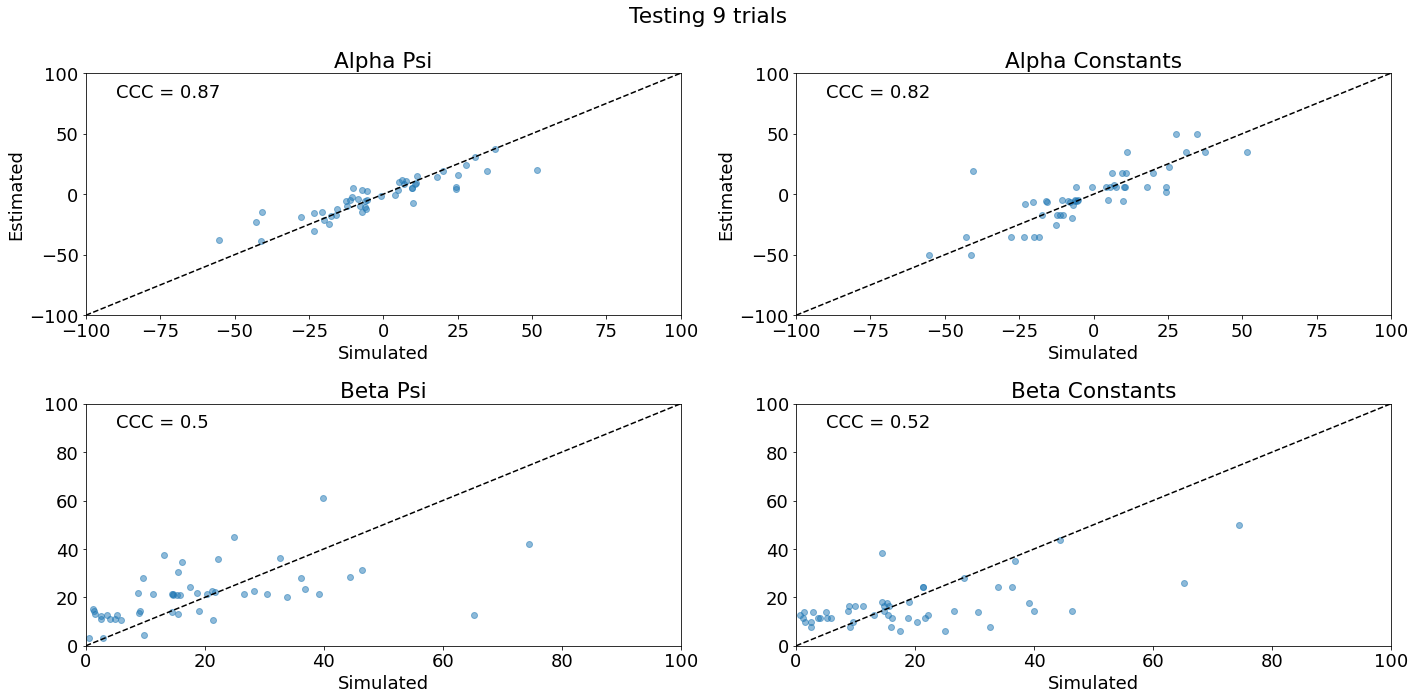

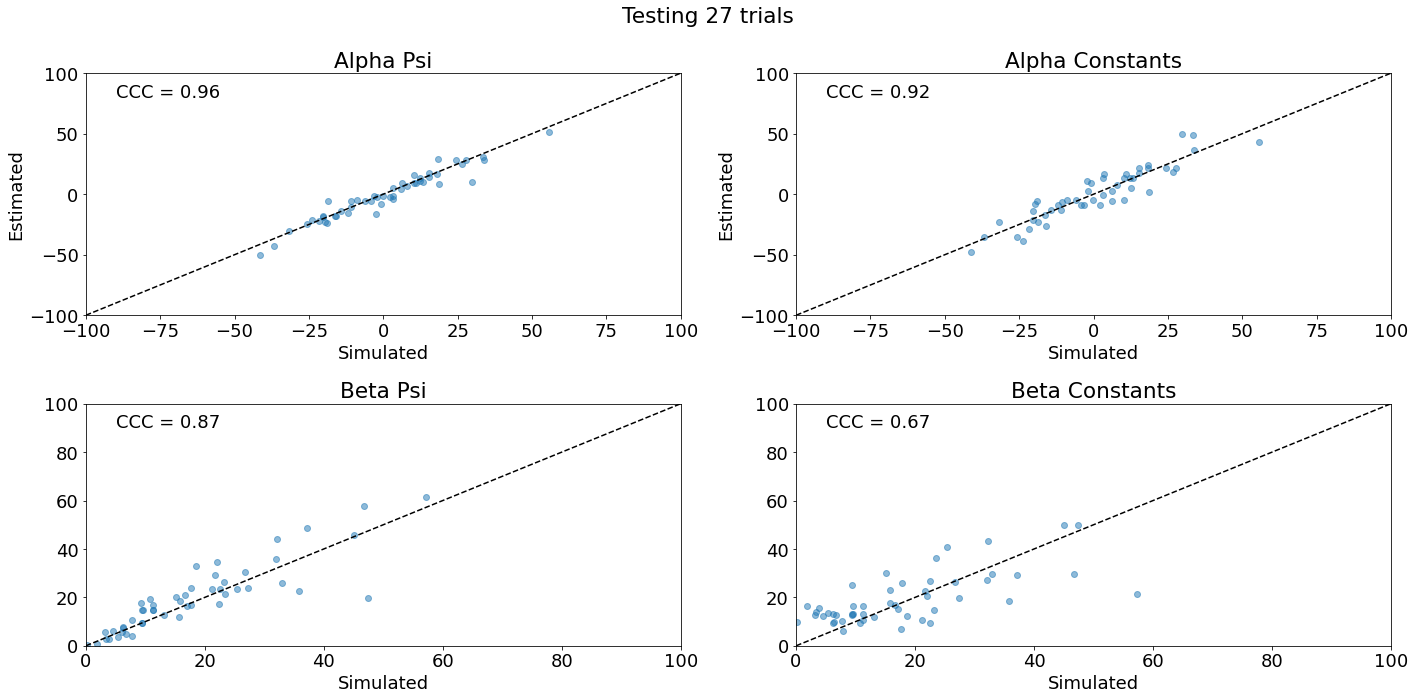

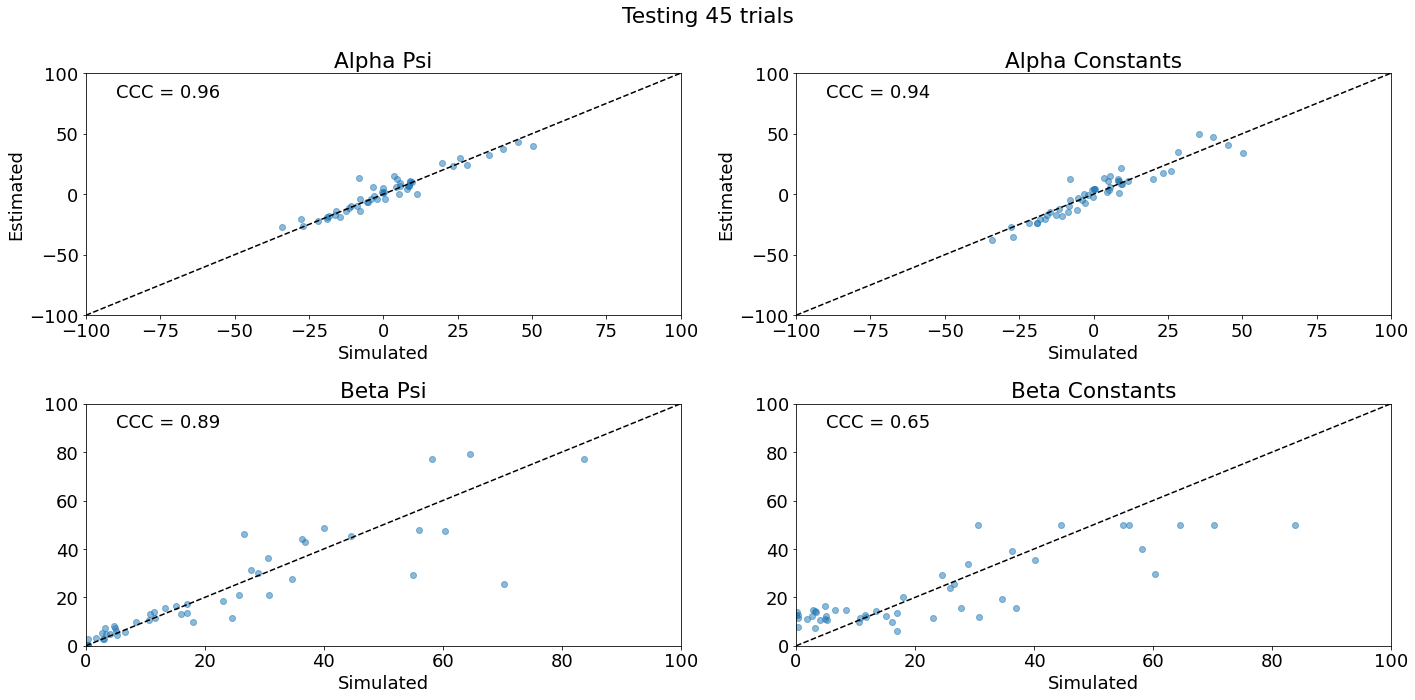

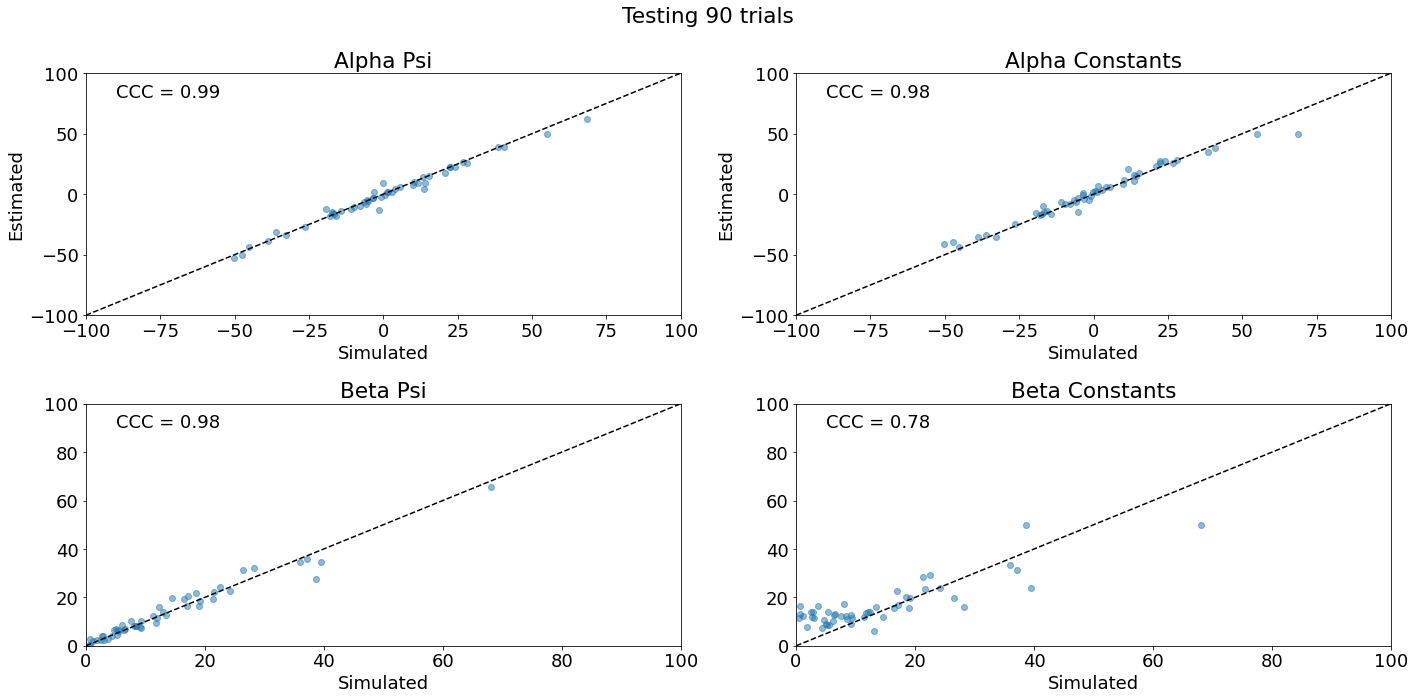

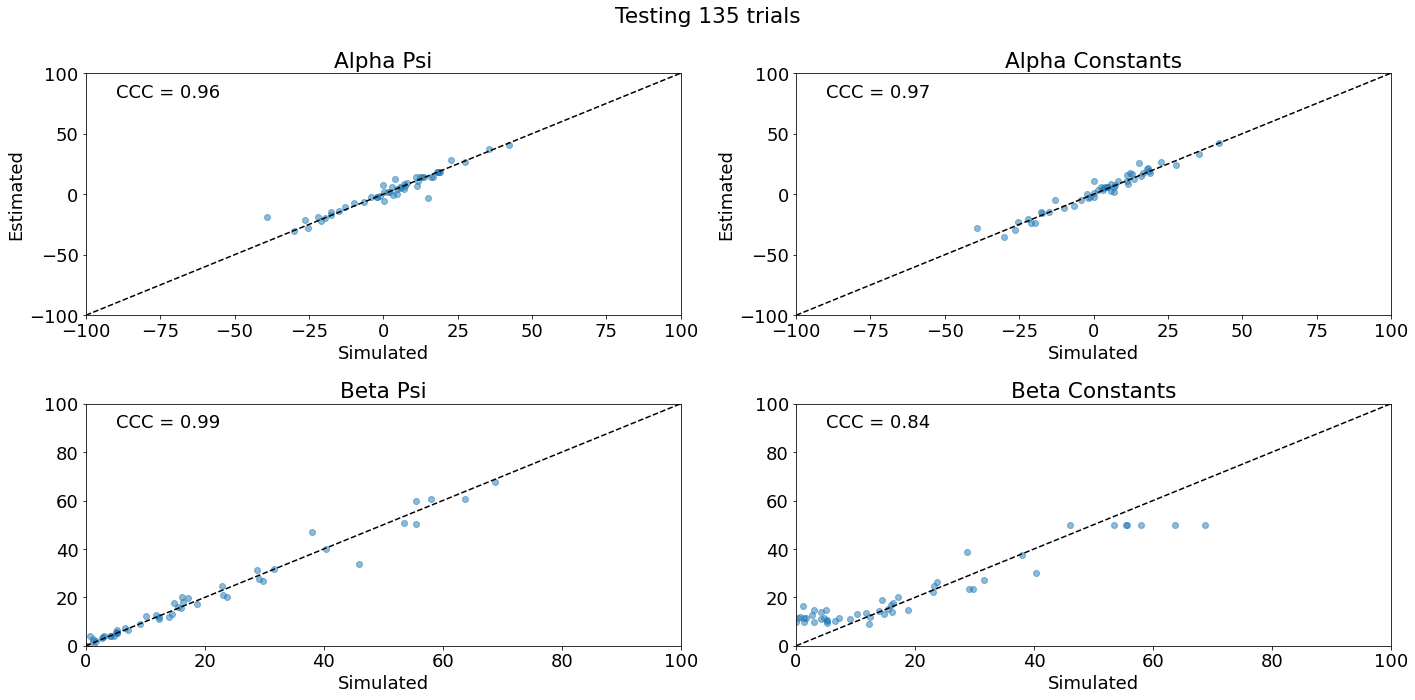

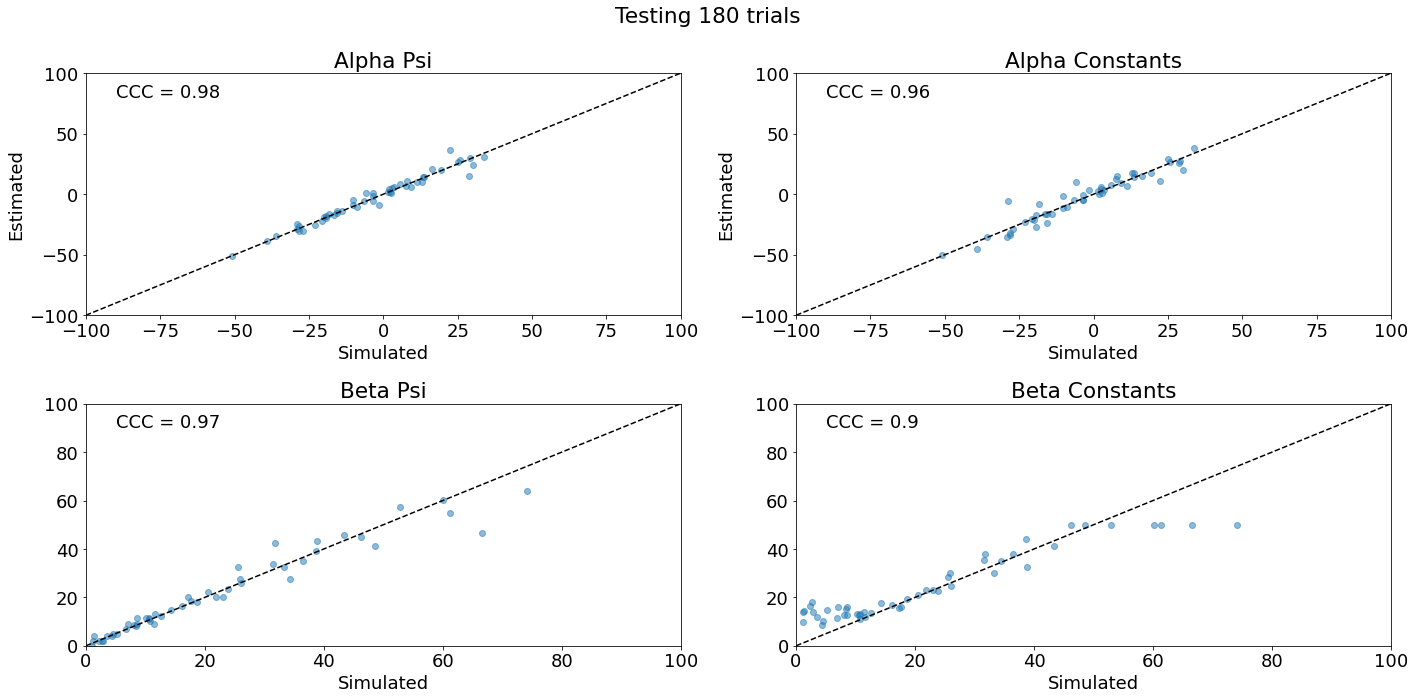

In [20]:
#Set some values for the expeirment
trials_per_stim = [1, 3, 5, 10, 15, 20]

Ntrials = [10, 25, 50, 75, 100, 150]
Nsubjs = 50

#Create the lookup tables
X = np.arange(-100,110,10)
a_range = np.linspace(-100,100)
b_range = np.linspace(0.001,100)
p_left_look, p_right_look = Psi_lookT(X,a_range,b_range)

#Set the priors
p_alpha = norm.pdf(a_range,0, 20)
p_beta = expon.pdf(b_range,0,20)
p_alpha = np.reshape(p_alpha,(1,len(p_alpha)))
p_beta = np.reshape(p_beta,(1,len(p_beta)))
Prior = p_beta.T @ p_alpha 

alpha_psi_ccc, alpha_const_ccc, beta_psi_ccc, beta_const_ccc = [],[],[],[]
for i, n in enumerate(trials_per_stim):
    
    Nstims = n*len(X_constants)
    alpha_sim, beta_sim, alpha_psi, beta_psi, alpha_constants, beta_constants = [],[],[],[],[],[]
    for s in range(Nsubjs):
        
        #Set the parameters
        alpha_sim = np.append(alpha_sim, norm.rvs(0,20))
        beta_sim = np.append(beta_sim, expon.rvs(0,20))
        params = [alpha_sim[s], beta_sim[s]]
        
        #Simulate Psi
        _, _, alpha_EV, beta_EV = sim_psi(params, Nstims, X, a_range, b_range, p_left_look, p_right_look, Prior)
        alpha_psi = np.append(alpha_psi, alpha_EV[-1]) 
        beta_psi = np.append(beta_psi, beta_EV[-1])

        #Simulate Constants 
        Kleft, p_left = sim_constants(params, X_constants, n)
        #Fit the constants data
        Nstims_vec = np.ones_like(X_constants)*n
        best_params, _ = Fit_psi(X_constants, Kleft, Nstims_vec, Num_Inits=30)

        alpha_constants = np.append(alpha_constants, best_params[0])
        beta_constants = np.append(beta_constants, best_params[1])
        
    alpha_psi_ccc = np.append(alpha_psi_ccc, calc_CCC(alpha_sim,alpha_psi))
    alpha_const_ccc = np.append(alpha_const_ccc, calc_CCC(alpha_sim,alpha_constants))
    beta_psi_ccc = np.append(beta_psi_ccc, calc_CCC(beta_sim,beta_psi))
    beta_const_ccc = np.append(beta_const_ccc, calc_CCC(beta_sim,beta_constants))
    
    #Plot
    fig, ax = plt.subplots(2,2,figsize=(20,10), tight_layout=True)
    ax[0,0].plot(alpha_sim,alpha_psi,'o', alpha=0.5)
    ax[0,0].plot(a_range,a_range,'k--')
    ax[0,0].text(-90,80,'CCC = ' + str(round(alpha_psi_ccc[i],2)))
    ax[0,0].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated',ylabel='Estimated',title='Alpha Psi')

    ax[1,0].plot(beta_sim,beta_psi,'o', alpha=0.5)
    ax[1,0].plot(b_range,b_range,'k--')
    ax[1,0].text(5,90,'CCC = ' + str(round(beta_psi_ccc[i],2)))
    ax[1,0].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated',title='Beta Psi')

    ax[0,1].plot(alpha_sim,alpha_constants,'o', alpha=0.5)
    ax[0,1].plot(a_range,a_range,'k--')
    ax[0,1].text(-90,80,'CCC = ' + str(round(alpha_const_ccc[i],2)))
    ax[0,1].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated',ylabel='Estimated',title='Alpha Constants')

    ax[1,1].plot(beta_sim,beta_constants,'o', alpha=0.5)
    ax[1,1].plot(b_range,b_range,'k--')
    ax[1,1].text(5,90,'CCC = ' + str(round(beta_const_ccc[i],2)))
    ax[1,1].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated',title='Beta Constants')
    fig.suptitle('Testing '+ str(Nstims) + ' trials')
    plt.show()

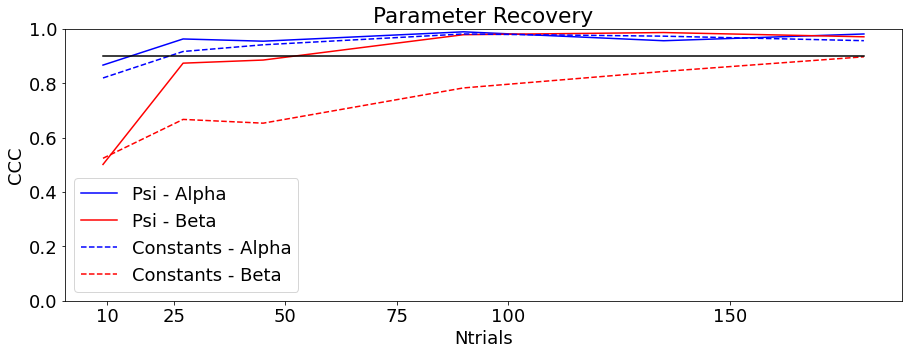

In [21]:
x_axis = np.array(trials_per_stim) * len(X_constants)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(x_axis,alpha_psi_ccc,'b-',label='Psi - Alpha')
ax.plot(x_axis,beta_psi_ccc,'r-',label='Psi - Beta')
ax.plot(x_axis,alpha_const_ccc,'b--',label='Constants - Alpha')
ax.plot(x_axis,beta_const_ccc,'r--',label='Constants - Beta')
ax.plot(x_axis,np.ones(len(Ntrials))*0.9,'k-')
ax.set(ylim=(0,1),ylabel='CCC',xlabel='Ntrials',title='Parameter Recovery',xticks=Ntrials)
plt.legend()
plt.show()    